In [1]:
#Required Installs
#!pip install fivecentplots # will need to remove for submission

In [2]:
#Standard Imports
import os

#Third Party Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, make_scorer
import xgboost as xgb
#import fivecentplots as fcp #clean data vis library for easy pandas integration | will need to remove for submission
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.impute import KNNImputer


In [3]:
train_raw = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv',index_col='Id')
test_raw = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv',index_col='Id')

#confirm data
train_raw.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
for col in train_raw.columns:
    print(f"NAN in {col}:  ", train_raw[col].isna().sum().sum())

NAN in AB:   0
NAN in AF:   0
NAN in AH:   0
NAN in AM:   0
NAN in AR:   0
NAN in AX:   0
NAN in AY:   0
NAN in AZ:   0
NAN in BC:   0
NAN in BD :   0
NAN in BN:   0
NAN in BP:   0
NAN in BQ:   60
NAN in BR:   0
NAN in BZ:   0
NAN in CB:   2
NAN in CC:   3
NAN in CD :   0
NAN in CF:   0
NAN in CH:   0
NAN in CL:   0
NAN in CR:   0
NAN in CS:   0
NAN in CU:   0
NAN in CW :   0
NAN in DA:   0
NAN in DE:   0
NAN in DF:   0
NAN in DH:   0
NAN in DI:   0
NAN in DL:   0
NAN in DN:   0
NAN in DU:   1
NAN in DV:   0
NAN in DY:   0
NAN in EB:   0
NAN in EE:   0
NAN in EG:   0
NAN in EH:   0
NAN in EJ:   0
NAN in EL:   60
NAN in EP:   0
NAN in EU:   0
NAN in FC:   1
NAN in FD :   0
NAN in FE:   0
NAN in FI:   0
NAN in FL:   1
NAN in FR:   0
NAN in FS:   2
NAN in GB:   0
NAN in GE:   0
NAN in GF:   0
NAN in GH:   0
NAN in GI:   0
NAN in GL:   1
NAN in Class:   0


In [5]:
#fcp.hist(df=train_raw, x='AB', kde=True, kde_width=2)

In [6]:
#Seperate out our target feature
X = train_raw.iloc[:, :-1]
y = train_raw.iloc[:, -1]

#Now is a good time to confirm a few things about our data:
# 1: lets check how our encoding looks and we can decide if we need a new approach
# 2: lets check the distribution of our target feature

print("Categorical spread for EJ:\n", X.EJ.value_counts())
print("istribution of target:\n", y.value_counts())

#impute NaN values
imputer = KNNImputer(n_neighbors=2, weights='uniform')

#Add encoding for our only categorical col
encoder = LabelEncoder()
X.EJ = encoder.fit_transform(X.EJ)
X_imp = imputer.fit_transform(X)
X = pd.DataFrame(X_imp, columns=X.columns)

#Now we'll generate our prediction CSV
X_val = test_raw
encoder = LabelEncoder()
imputer = KNNImputer(n_neighbors=2, weights='uniform')
X_val.EJ = encoder.fit_transform(X_val.EJ)
X_val_imp = imputer.fit_transform(X_val)
X_val = pd.DataFrame(X_val_imp, columns=X_val.columns)

#finally we want to convert our testdata to an xgb.Dmatrix
val_index = X_val.index
X_val = xgb.DMatrix(X_val)

#define problem specific balanced log loss function
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

Categorical spread for EJ:
 B    395
A    222
Name: EJ, dtype: int64
istribution of target:
 0    509
1    108
Name: Class, dtype: int64


In [7]:
'''
%%time

#HYPERPARAM TUNING, make sure to turn it off before submission!!!
from xgboost import XGBClassifier

# Define our classifier
clf = XGBClassifier(
    learning_rate=0.005,
    objective='multi:softprob',
    num_class=2,
    eval_metric='auc',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    max_bin=623,
    max_depth=3,
    gamma=2,
    reg_lambda=5,
    colsample_bytree=0.75,
    subsample=0.85,
    min_child_weight=5,
    n_jobs=-1  # Use all CPU cores
)

# Create a scorer
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True)

# Define our parameter grid
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 9],  # Increase max_depth for higher complexity
    'gamma': [0.5, 1, 2],  # Vary the minimum loss reduction to create a new split
    'reg_lambda': [1, 5, 10],  # Vary the L2 regularization term
    'subsample': [0.6, 0.8, 1.0],  # Vary the fraction of observations to subsample
    'colsample_bytree': [0.6, 0.8, 1.0]  # Vary the fraction of columns to sample
}

# Initialize GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=4, scoring=balanced_log_loss_scorer)

# Fit GridSearchCV
grid_clf.fit(X, y)

# Get the best parameters
best_parameters = grid_clf.best_params_

print(f"Best parameters: {best_parameters}")
'''


'\n%%time\n\n#HYPERPARAM TUNING, make sure to turn it off before submission!!!\nfrom xgboost import XGBClassifier\n\n# Define our classifier\nclf = XGBClassifier(\n    learning_rate=0.005,\n    objective=\'multi:softprob\',\n    num_class=2,\n    eval_metric=\'auc\',\n    tree_method=\'gpu_hist\',\n    predictor=\'gpu_predictor\',\n    gpu_id=0,\n    max_bin=623,\n    max_depth=3,\n    gamma=2,\n    reg_lambda=5,\n    colsample_bytree=0.75,\n    subsample=0.85,\n    min_child_weight=5,\n    n_jobs=-1  # Use all CPU cores\n)\n\n# Create a scorer\nbalanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True)\n\n# Define our parameter grid\nparam_grid = {\n    \'max_depth\': [1, 2, 3, 5, 7, 9],  # Increase max_depth for higher complexity\n    \'gamma\': [0.5, 1, 2],  # Vary the minimum loss reduction to create a new split\n    \'reg_lambda\': [1, 5, 10],  # Vary the L2 regularization term\n    \'subsample\': [0.6, 0.8, 1.0],  # Vary the fraction of o

In [8]:
#setting our tuned values up to use without the sklearn API for later
best_parameters = {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 7, 'reg_lambda': 1, 'subsample': 1.0}

"""
xgb_params=  {'learning_rate': 0.005,
                'objective': 'multi:softprob',
                'num_class': 2,
                'eval_metric': 'auc',
                'tree_method': 'gpu_hist',
                'predictor': 'gpu_predictor',
                'gpu_id': 0,
                'max_bin': 623,
                'max_depth': best_parameters['max_depth'],
                'gamma': best_parameters['gamma'],
                'reg_lambda': best_parameters['reg_lambda'],
                'colsample_bytree': best_parameters['colsample_bytree'],
                'subsample': best_parameters['subsample'],
                'min_child_weight': 5,
             }
"""
xgb_params= {'learning_rate': 0.7,
                'max_depth': 2,
                'tree_method': 'gpu_hist',
                'predictor': 'gpu_predictor',
                'gpu_id': 0,
                'objective': 'multi:softprob',
                'num_class': 2,
                'min_child_weight': 7,
                'max_bin': 100,
            }

In [9]:
%%time

train_oof = np.zeros((X[X.columns].shape[0],))
test_preds = 0
train_oof_shap = np.zeros((X[X.columns].shape[0], X[X.columns].shape[1]+1))
test_preds_shap = 0
train_oof_shap.shape
weights = np.zeros(len(y))

NUM_FOLDS = 5
early_stopping_rounds = 30
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

# List to store the best iteration of each fold
best_iterations = []

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind][X.columns], X.iloc[val_ind][X.columns]
        train_target, val_target = y[train_ind], y[val_ind]
        
        weights = np.zeros(len(train_target))

        # 0 is the majority class in this case by a fair ammount
        weights[train_target == 0] = 1
        weights[train_target == 1] = sum(train_target == 0) / sum(train_target == 1)
        
        train_df = xgb.DMatrix(train_df, label=train_target, weight=weights)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        # The watchlist is used for early stopping
        watchlist = [(train_df, 'train'), (val_df, 'eval')]

        model = xgb.train(xgb_params, train_df, evals=watchlist, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        
        # Append the best iteration of this fold to the list
        best_iterations.append(model.best_iteration)
        
        temp_oof = model.predict(val_df, iteration_range=(0, model.best_iteration + 1))[:,1]
        temp_oof_shap = model.predict(val_df, iteration_range=(0, model.best_iteration + 1), pred_contribs=True)[:,1]
        temp_test = model.predict(X_val, iteration_range=(0, model.best_iteration + 1))[:,1]
        temp_test_shap = model.predict(X_val, iteration_range=(0, model.best_iteration + 1), pred_contribs=True)[:,1]

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        train_oof_shap[val_ind, :] = temp_oof_shap
        test_preds_shap += temp_test_shap/NUM_FOLDS
        
        
        print(balanced_log_loss(val_target, temp_oof))
        
print(f"Mean balanced log loss: {balanced_log_loss(y, train_oof)}")

median_best_iteration = round(np.median(best_iterations))
print(f"Median best iteration: {median_best_iteration}")

3it [00:00,  4.13it/s]

0.362633384562521
0.3669391047867859
0.3433259341025179
0.2713189449225146


5it [00:00,  5.01it/s]

0.246222179805292
Mean balanced log loss: 0.3181351850542224
Median best iteration: 9
CPU times: user 665 ms, sys: 290 ms, total: 955 ms
Wall time: 1.01 s


In [10]:
#now that we have assessed the model we want to train it on all of our availible data:
weights = np.zeros(len(y))

# 0 is the majority class in this case by a fair ammount
weights[y == 0] = 1
weights[y == 1] = sum(y == 0) / sum(y == 1)

full_train_df = xgb.DMatrix(X, label=y, weight=weights)
final_model = xgb.train(xgb_params, full_train_df, num_boost_round=median_best_iteration)

In [11]:
y_preds = model.predict(X_val, output_margin=False)

submission = pd.DataFrame()
submission["Id"] = val_index

submission["class_0"] = y_preds[:,0]
submission["class_1"] = y_preds[:,1]


In [12]:
submission.head()

,Id,class_0,class_1
0,0,0.832918,0.167082
1,1,0.832918,0.167082
2,2,0.832918,0.167082
3,3,0.832918,0.167082
4,4,0.832918,0.167082


In [13]:
submission.to_csv("submission.csv",header=True,index=False)

`
%%time
#simple testing ~
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='aucpr', scale_pos_weight = ratio))
])

# Specify the hyperparameters and their values
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [2, 4, 6],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Create a KFold object
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")
`

In [14]:
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)
np.save('train_oof_shap', train_oof_shap)
np.save('test_preds_shap', test_preds_shap)

In [15]:
%matplotlib inline
import cudf, cuml
import cupy as cp

from cuml.manifold import TSNE, UMAP
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim

In [16]:
train_df = cudf.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [17]:
train = cp.load('/kaggle/working/train_oof_shap.npy')
test = cp.load('/kaggle/working/test_preds_shap.npy')

In [18]:
train_test = cp.vstack([train, test])
train_test.shape

(622, 57)

In [19]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(train_test)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


CPU times: user 11.9 s, sys: 319 ms, total: 12.2 s
Wall time: 13.4 s


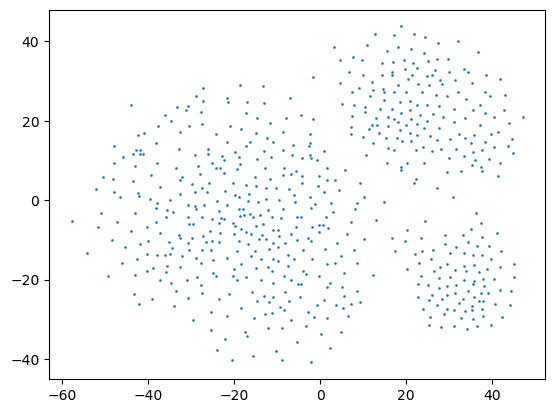

In [20]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), s = 0.8)

In [21]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(train)

CPU times: user 325 ms, sys: 8.9 ms, total: 334 ms
Wall time: 331 ms


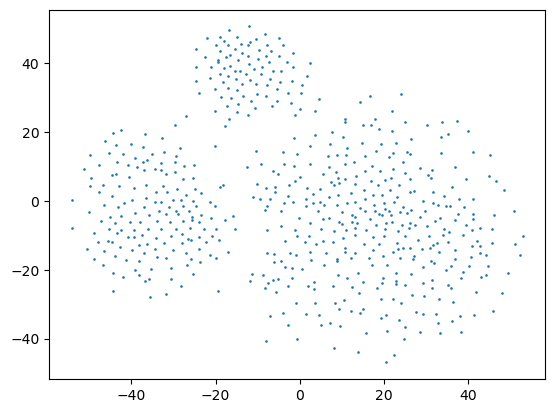

In [22]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), s = 0.8)

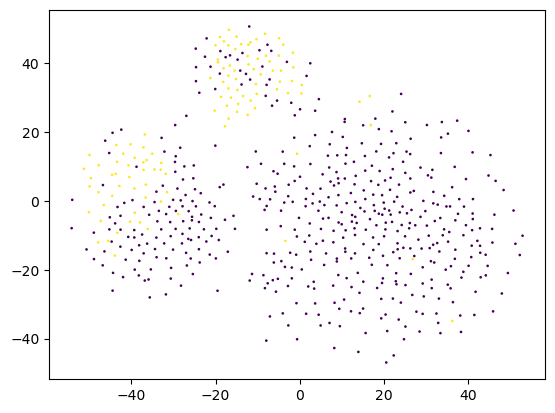

In [23]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), c=train_df['Class'].values.get(), s = 0.8)

In [24]:
%%time
umap = UMAP(n_components=2)
train_2D = umap.fit_transform(train)

CPU times: user 898 ms, sys: 130 ms, total: 1.03 s
Wall time: 1.54 s


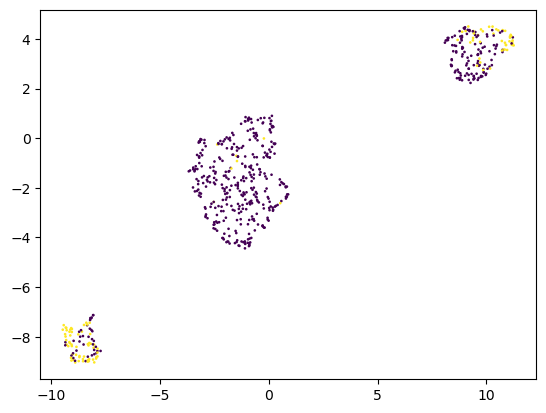

In [25]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), c=train_df['Class'].values.get(), s = 0.8)